In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
import seaborn as sns
from astropy.cosmology import WMAP9 as cosmo
import pandas as pd
import matplotlib.ticker as ticker


import Window_Function
import window_function_2
import HERA_hack_FG
import pspec
import make_universe

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize']=11
plt.rcParams['xtick.labelsize']=11



%load_ext autoreload
%autoreload 2

In [217]:
pbeam = False 
norm = True 


npix_row,npix_col = 60,60

npix_tot = npix_row * npix_col

Ly = 2000
Lx = 2000

nbins = 50


In [218]:
################## TELESCOPE STUFF ##################
dishes = np.array([[0,0],[0,-57.39295490174667],[30,0],[0,60],[2,55],[47,2],[45,23],[56,21],[30,115],[48,52],[100,100],[0,200],[115,30],[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55],[200,0],[145,13],[134,65],[139,163]])
data = np.loadtxt('/Users/hannahfronenberg/desktop/MSC1/HERA Noise/hera_positions_staged/antenna_positions_128.dat')
hera_bls = data[:,:-1]


#dishes = np.array([[0,0],[33.33,0],[0,70.71],[33.33, 70.71]])
acorner = np.array([[120,270],[122,280],[120,280],[122,270]])

HERA = HERA_hack_FG.telescope(dishes, latitude=-30, channel_width=0.1, Tsys=300, beam_width=2, beam = 'gaussian')

obs = HERA_hack_FG.observation(telescope = HERA, n_days = 1, freq = 150, delta_t = 0.01 ,corners = acorner, beam_sigma_cutoff=2.5, sky_shape = (npix_row,npix_col), norm = norm, pbeam = pbeam)

obs.compute_M(None,None)

############# DEFINE FAKE UNIVERSE SPEC #########


def ps(x):
    mu, sigma = 0.027348316,0.004
    return  np.exp( - (x - mu)**2 / (2 * sigma**2))
#     return np.sin(100*x)

make_uni = make_universe.universe(ps,obs.sky_shape[0],obs.sky_shape[1],Ly,Lx, mean = None) #100 Mpc by 100Mpc




In [4]:
HERA.remove_redundant_bls()

HERA.N_bls

433

In [5]:
nreals = 100

ave_Cij = np.zeros((npix_tot,npix_tot))
ck_ave = np.zeros((npix_tot,npix_tot), dtype = complex)
cov_spec = np.zeros(npix_tot,dtype = complex)
obs_spec = np.zeros(nbins-1)
k_hera = []


for i in range(nreals): 
    
    universe, universe_stdev = make_uni.make_2D_universe()
    
    power_spec_stdev = pspec.Power_Spectrum(universe_stdev,Ly,Lx,nbins,False) #100 Mpc by 100M
    power_spec_stdev.cosmo_FFT2()

   
    spec_cov = np.reshape(power_spec_stdev.ps_data, (3600,))
    cov_spec += spec_cov #find the average spec

   
    
    fft_uni = np.reshape(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(universe_stdev))), (npix_tot,))
    ck = np.outer(fft_uni,np.conj(fft_uni).T)
    ck_ave += ck
    

    stacked_sky = np.hstack(universe_stdev).T
    sky = np.real(obs.convolve_map(stacked_sky,None,None))
    square_sky = np.reshape(sky,(npix_row,npix_col)).T # do not include .T here for window functioning! (I think)
    
    
    fft_sky = np.reshape(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(square_sky))), (npix_tot,))
    power_spec_obs = pspec.Power_Spectrum(square_sky.T,Ly,Lx,nbins,False)
    pk_hera = power_spec_obs.compute_2D_pspec()
    obs_spec += pk_hera[1]
    
    if i == 0:#make sure to save the ks!
        k_hera = pk_hera[0]
    else:
        pass

    C_ij_obs = np.real(np.outer(fft_sky,(np.conj(fft_sky).T)))
    ave_Cij += C_ij_obs 


ave_Cij /= nreals
ave_Cij = np.diag(ave_Cij)
ck_ave_diag = np.diag(ck_ave)
ck_ave_diag = np.real(ck_ave_diag)/nreals
cov_spec /= nreals
obs_spec /= nreals

/Users/hannahfronenberg/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


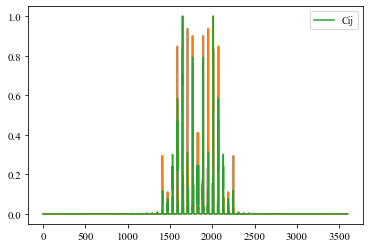

In [8]:
plt.plot(np.dot(window.window,ck_ave_diag)/max(np.dot(window.window,ck_ave_diag)))
plt.plot(np.dot(window.window,cov_spec)/max(np.dot(window.window,cov_spec)))
plt.plot(ave_Cij/max(ave_Cij), label = 'Cij')
plt.legend()

In [9]:
indices = np.argsort(window.k) #find the indices that sort self.

cii_sorted = np.take(ave_Cij,indices)#axis 1 sorts the columns into the right order
cii_sorted = np.asarray(cii_sorted)#why is this transpose here??? I think because of reshaping but check

hist, bin_edges = np.histogram(window.k_sorted, bins = nbins)
cii_sorted_binned = np.zeros(nbins)

min_index = 0
for i in range(len(bin_edges)-1): #pick a bin!
    max_index = np.sum(hist[:i+1])#hist[i] + min_index 
    min_index = np.sum(hist[:i])
    a = np.sum(cii_sorted[min_index:max_index]) #for row j, sum the columns from min to max index of the bin
    c = hist[i] #number of P_k values in that bin 
    cii_sorted_binned[i] = a/c #compute average W that bin


In [13]:
window = window_function_2.Window_Function(obs.Mmat,obs.sky_shape[0],obs.sky_shape[1],Lx,Ly,150,nbins)

window_cov_spec = window.compute_pspec_estimate(cov_spec) #lines 3 an 4 should be exactly the same 
ps_spec_ave = window.compute_pspec_estimate(cov_spec/(33.333*33.333)**2)
ps_spec_theory  =  window.compute_pspec_estimate(ps)

/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/window_function_2.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  self.pk_window_binned[i] = a/c #compute average W that bin


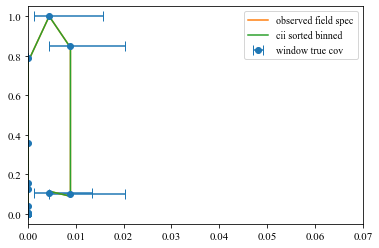

In [73]:
plt.errorbar(window.k_to_plot,window_cov_spec[1]/max(window_cov_spec[1]), xerr = window.error_bars,fmt = 'o' ,capsize=5,label = 'window true cov')
plt.xlim(0,0.07)
plt.plot(window.k_to_plot,obs_spec/max(obs_spec), label = 'observed field spec')
plt.plot(window.k_to_plot,cii_sorted_binned[1:]/max(cii_sorted_binned[1:]), label = 'cii sorted binned')
plt.legend()

In [229]:
print(window.reduced_k)

[0.003 0.004 0.006 0.007 0.009 0.01  0.011 0.013 0.014 0.016 0.017 0.018
 0.019 0.02  0.021 0.022 0.023 0.024 0.025 0.026 0.027 0.028 0.029 0.03
 0.031 0.032 0.033 0.034 0.035 0.036 0.037 0.038 0.039 0.04  0.041 0.042
 0.043 0.044 0.045 0.046 0.047 0.048 0.049 0.05  0.051 0.052 0.053 0.054
 0.055 0.056 0.057 0.058 0.059 0.06  0.061 0.062 0.063 0.064 0.065 0.066
 0.067 0.068 0.069 0.07  0.071 0.072 0.073 0.074 0.075 0.076 0.077 0.078
 0.079 0.08  0.081 0.082 0.083 0.084 0.085 0.086 0.087 0.088 0.089 0.09
 0.091 0.092 0.093 0.094 0.095 0.096 0.097 0.098 0.099 0.1   0.101 0.102
 0.103 0.104 0.105 0.106 0.107 0.108 0.109 0.11  0.111 0.112 0.113 0.114
 0.115 0.116 0.117 0.118 0.119 0.12  0.121 0.122 0.123 0.124 0.125 0.127
 0.129 0.131 0.133]


In [231]:
np.argwhere(window.reduced_k == 0.08) #53-73

array([[73]])

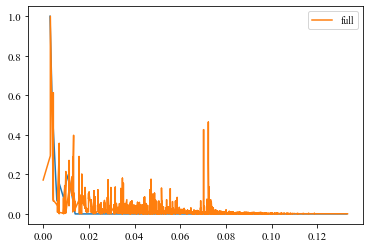

In [224]:
plt.plot(window.reduced_k,window.window_binned[40]/max(window.window_binned[40]))
plt.plot(window.k_sorted, window.window_sorted[3000]/max(window.window_sorted[3000]), label = 'full')
plt.legend()

In [215]:
window.compute_error_bars()

(50, 3600)


Text(0, 0.5, 'W(k)')

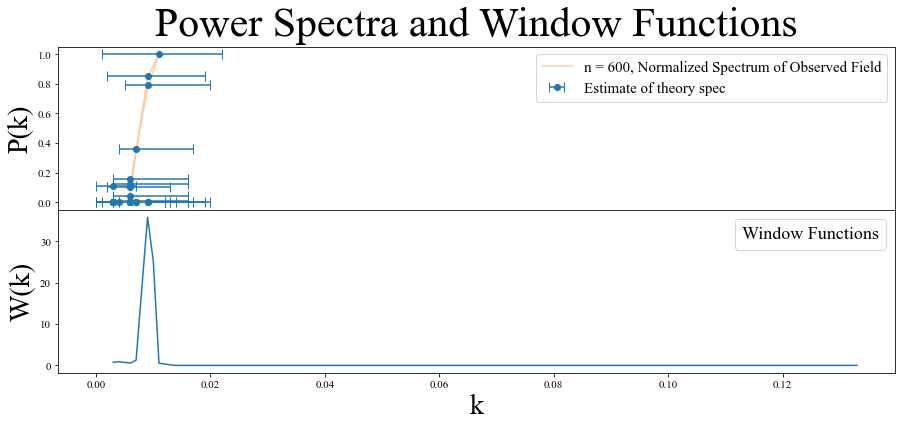

In [241]:
fig, ax = plt.subplots(2, 1, figsize = (15,6),sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})

ax[0].errorbar(window.k_to_plot,window_cov_spec[1]/max(window_cov_spec[1]),  xerr = window.error_bars,fmt = 'o' ,capsize=5,label = 'Estimate of theory spec')
ax[0].plot(window.k_to_plot,obs_spec/max(obs_spec), alpha = 0.4 ,label = 'n = 600, Normalized Spectrum of Observed Field')

ax[0].set_ylabel('P(k)',fontsize = 28)
ax[0].set_title('Power Spectra and Window Functions',fontsize = 42 , y = 1.03)
ax[0].legend(fontsize = 15)


ax[1].plot(window.reduced_k,window.window_binned[2])


ax[1].legend(['Window Functions'], fontsize = 18, handletextpad=0, handlelength=0)
ax[1].set_xlabel('k',fontsize = 28)
ax[1].set_ylabel('W(k)',fontsize = 28)

In [193]:
print(window.reduced_k.shape)

(440,)


In [197]:
window.bin_window()
print(window.window_binned.shape)

(50, 3600)
(49, 439)
(49, 439)


In [169]:
print(window.reduced_k)

[0.    0.003 0.004 0.006 0.007 0.009 0.01  0.011 0.013 0.014 0.016 0.017
 0.018 0.019 0.02  0.021 0.022 0.023 0.024 0.025 0.026 0.027 0.028 0.029
 0.03  0.031 0.032 0.033 0.034 0.035 0.036 0.037 0.038 0.039 0.04  0.041
 0.042 0.043 0.044 0.045 0.046 0.047 0.048 0.049 0.05  0.051 0.052 0.053
 0.054 0.055 0.056 0.057 0.058 0.059 0.06  0.061 0.062 0.063 0.064 0.065
 0.066 0.067 0.068 0.069 0.07  0.071 0.072 0.073 0.074 0.075 0.076 0.077
 0.078 0.079 0.08  0.081 0.082 0.083 0.084 0.085 0.086 0.087 0.088 0.089
 0.09  0.091 0.092 0.093 0.094 0.095 0.096 0.097 0.098 0.099 0.1   0.101
 0.102 0.103 0.104 0.105 0.106 0.107 0.108 0.109 0.11  0.111 0.112 0.113
 0.114 0.115 0.116 0.117 0.118 0.119 0.12  0.121 0.122 0.123 0.124 0.125
 0.127 0.129 0.131 0.133]


In [112]:
rounded_k = np.around(window.k_sorted, decimals = 3)
reduced_k = np.sort(list(set(rounded_k)))

In [133]:
binned = []

for i in range(len(reduced_k)):# pick a bin
    a = 0
    c = 0
    for j in range(len(window.k_sorted)): # check which elements are in that bin
        
        if reduced_k[i] == np.around(window.k_sorted[j], decimals = 3):
            a += window.window_sorted[:,j]
            c += 1
        else:
            pass
        
    binned.append(a/c)


             

0 0
1 1
1 2
1 3
1 4
2 5
2 6
2 7
2 8
3 9
3 10
3 11
3 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
5 21
5 22
5 23
5 24
5 25
5 26
5 27
5 28
6 29
6 30
6 31
6 32
6 33
6 34
6 35
6 36
7 37
7 38
7 39
7 40
7 41
7 42
7 43
7 44
8 45
8 46
8 47
8 48
8 49
8 50
8 51
8 52
8 53
8 54
8 55
8 56
8 57
8 58
8 59
8 60
9 61
9 62
9 63
9 64
9 65
9 66
9 67
9 68
10 69
10 70
10 71
10 72
10 73
10 74
10 75
10 76
10 77
10 78
10 79
10 80
10 81
10 82
10 83
10 84
10 85
10 86
10 87
10 88
11 89
11 90
11 91
11 92
11 93
11 94
11 95
11 96
12 97
12 98
12 99
12 100
12 101
12 102
12 103
12 104
12 105
12 106
12 107
12 108
13 109
13 110
13 111
13 112
13 113
13 114
13 115
13 116
13 117
13 118
13 119
13 120
14 121
14 122
14 123
14 124
14 125
14 126
14 127
14 128
14 129
14 130
14 131
14 132
14 133
14 134
14 135
14 136
15 137
15 138
15 139
15 140
15 141
15 142
15 143
15 144
16 145
16 146
16 147
16 148
16 149
16 150
16 151
16 152
16 153
16 154
16 155
16 156
16 157
16 158
16 159
16 160
17 161
17 162
17 163
17 164
17 165
17 166
17 167
17 

55 1177
55 1178
55 1179
55 1180
55 1181
55 1182
55 1183
55 1184
55 1185
55 1186
55 1187
55 1188
55 1189
55 1190
55 1191
55 1192
55 1193
55 1194
55 1195
55 1196
55 1197
55 1198
55 1199
55 1200
56 1201
56 1202
56 1203
56 1204
56 1205
56 1206
56 1207
56 1208
56 1209
56 1210
56 1211
56 1212
56 1213
56 1214
56 1215
56 1216
56 1217
56 1218
56 1219
56 1220
56 1221
56 1222
56 1223
56 1224
56 1225
56 1226
56 1227
56 1228
56 1229
56 1230
56 1231
56 1232
56 1233
56 1234
56 1235
56 1236
57 1237
57 1238
57 1239
57 1240
57 1241
57 1242
57 1243
57 1244
57 1245
57 1246
57 1247
57 1248
57 1249
57 1250
57 1251
57 1252
57 1253
57 1254
57 1255
57 1256
57 1257
57 1258
57 1259
57 1260
57 1261
57 1262
57 1263
57 1264
57 1265
57 1266
57 1267
57 1268
57 1269
57 1270
57 1271
57 1272
57 1273
57 1274
57 1275
57 1276
57 1277
57 1278
57 1279
57 1280
58 1281
58 1282
58 1283
58 1284
58 1285
58 1286
58 1287
58 1288
58 1289
58 1290
58 1291
58 1292
58 1293
58 1294
58 1295
58 1296
58 1297
58 1298
58 1299
58 1300
58 1301


81 2408
81 2409
81 2410
81 2411
81 2412
81 2413
81 2414
81 2415
81 2416
81 2417
81 2418
81 2419
81 2420
81 2421
81 2422
81 2423
81 2424
81 2425
81 2426
81 2427
81 2428
81 2429
81 2430
81 2431
81 2432
82 2433
82 2434
82 2435
82 2436
82 2437
82 2438
82 2439
82 2440
82 2441
82 2442
82 2443
82 2444
82 2445
82 2446
82 2447
82 2448
82 2449
82 2450
82 2451
82 2452
82 2453
82 2454
82 2455
82 2456
82 2457
82 2458
82 2459
82 2460
82 2461
82 2462
82 2463
82 2464
82 2465
82 2466
82 2467
82 2468
82 2469
82 2470
82 2471
82 2472
82 2473
82 2474
82 2475
82 2476
82 2477
82 2478
82 2479
82 2480
82 2481
82 2482
82 2483
82 2484
82 2485
82 2486
82 2487
82 2488
82 2489
82 2490
82 2491
82 2492
83 2493
83 2494
83 2495
83 2496
83 2497
83 2498
83 2499
83 2500
83 2501
83 2502
83 2503
83 2504
83 2505
83 2506
83 2507
83 2508
83 2509
83 2510
83 2511
83 2512
83 2513
83 2514
83 2515
83 2516
83 2517
83 2518
83 2519
83 2520
83 2521
83 2522
83 2523
83 2524
83 2525
83 2526
83 2527
83 2528
83 2529
83 2530
83 2531
83 2532


110 3455
110 3456
110 3457
110 3458
110 3459
110 3460
110 3461
110 3462
110 3463
110 3464
110 3465
110 3466
110 3467
110 3468
110 3469
110 3470
110 3471
110 3472
110 3473
110 3474
110 3475
110 3476
110 3477
110 3478
110 3479
110 3480
110 3481
110 3482
111 3483
111 3484
111 3485
111 3486
112 3487
112 3488
112 3489
112 3490
112 3491
112 3492
112 3493
112 3494
112 3495
112 3496
112 3497
112 3498
112 3499
112 3500
112 3501
112 3502
112 3503
112 3504
112 3505
112 3506
112 3507
112 3508
112 3509
112 3510
113 3511
113 3512
113 3513
113 3514
114 3515
114 3516
114 3517
114 3518
114 3519
114 3520
114 3521
114 3522
114 3523
114 3524
114 3525
114 3526
114 3527
114 3528
114 3529
114 3530
114 3531
114 3532
114 3533
114 3534
115 3535
115 3536
115 3537
115 3538
116 3539
116 3540
116 3541
116 3542
116 3543
116 3544
116 3545
116 3546
116 3547
116 3548
116 3549
116 3550
116 3551
116 3552
116 3553
116 3554
117 3555
117 3556
117 3557
117 3558
118 3559
118 3560
118 3561
118 3562
118 3563
118 3564
118 3565
1

AttributeError: 'list' object has no attribute 'T'

In [134]:
print(window.k_sorted[:40])

[0.         0.00314159 0.00314159 0.00314159 0.00314159 0.00444288
 0.00444288 0.00444288 0.00444288 0.00628319 0.00628319 0.00628319
 0.00628319 0.00702481 0.00702481 0.00702481 0.00702481 0.00702481
 0.00702481 0.00702481 0.00702481 0.00888577 0.00888577 0.00888577
 0.00888577 0.00942478 0.00942478 0.00942478 0.00942478 0.00993459
 0.00993459 0.00993459 0.00993459 0.00993459 0.00993459 0.00993459
 0.00993459 0.01132717 0.01132717 0.01132717]
